# AutoGen showcase

- Examples adapted from Notebook section of https://github.com/microsoft/autogen
- Created by John Tan Chong Min on 23 Jan 2024

In [57]:
# install autogen if you haven't already
# !pip install pyautogen

In [19]:
# fill in with your API key
my_api_key = 'YOUR_API_KEY_HERE'

# Single Chat to do stuff
- Simulates ChatGPT web interface

In [53]:
import autogen
from autogen import AssistantAgent, UserProxyAgent
config_list = [{'model': 'gpt-3.5-turbo', 'api_key': my_api_key},]

# You can also set config_list directly as a list, for example, config_list = [{'model': 'gpt-4', 'api_key': '<your OpenAI API key here>'},]
assistant = AssistantAgent("assistant", llm_config={"config_list": config_list})
user_proxy = UserProxyAgent("user_proxy", code_execution_config={"work_dir": "coding", "use_docker": False}) # IMPORTANT: set to True to run code in docker, recommended
user_proxy.initiate_chat(assistant, message="Give me 3 benefits of AutoGen")
# This initiates an automated chat between the two agents to solve the task


user_proxy (to assistant):

Give me 3 benefits of AutoGen

--------------------------------------------------------------------------------
assistant (to user_proxy):

AutoGen is a powerful tool that can be used to automate the generation of code or configuration files. Here are three benefits of using AutoGen:

1. Increased productivity: AutoGen allows you to automate repetitive tasks involved in generating code or configuration files. This can save you a significant amount of time and effort, increasing your productivity. You can define templates or rules to generate the desired code or files, and AutoGen will handle the generation process for you.

2. Consistency and accuracy: With AutoGen, you can ensure consistency and accuracy in your generated code or configuration files. By defining templates or rules, you can enforce specific standards and conventions. This helps to eliminate human error and ensures that the generated code or files are always consistent and accurate.

3. Flexi

Provide feedback to assistant. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  exit


# See Chart in Jupyter Lab
- Agent that executes code out natively in the Jupyter Notebook environment, and can display the figures

In [32]:
from typing import Dict, Union

from IPython import get_ipython
from IPython.display import Image

In [33]:
class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return (
            super().generate_init_message(*args, **kwargs)
            + """
If you suggest code, the code will be executed in IPython."""
        )

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

ipython_user_proxy (to assistant):

Plot a chart of y = x^2
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

To plot a chart of y = x^2, you can use the `matplotlib` library in Python. Here's the code to plot the chart:

```python
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)  # Generate 100 points between -10 and 10
y = x ** 2  # Calculate the y values

plt.plot(x, y)  # Plot the chart
plt.xlabel('x')
plt.ylabel('y')
plt.title('y = x^2')
plt.grid(True)
plt.show()
```

Executing this code will generate a chart with the x-axis ranging from -10 to 10 and the y-axis representing the squares of the corresponding x-values.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...


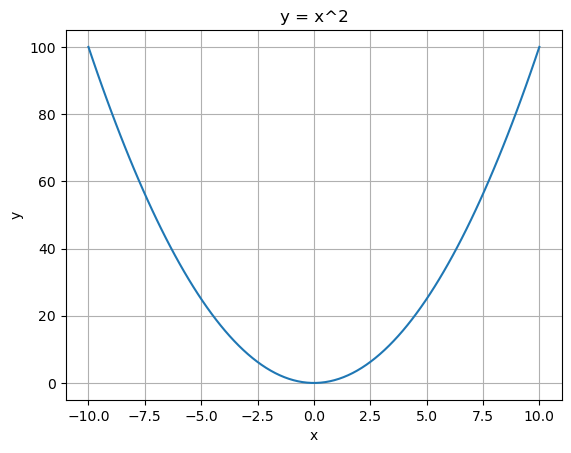

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

Great! The code executed successfully without any errors. It should have generated a chart of the function y = x^2. You can now see the chart plotted in a separate window. 
If you need any further assistance, feel free to ask.

--------------------------------------------------------------------------------
ipython_user_proxy (to assistant):



--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [34]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE")
    or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of y = x^2""",
)

# Group Chat

In [54]:
llm_config = {"config_list": config_list}
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 2,
        "work_dir": "groupchat",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    human_input_mode="TERMINATE",
)
coder = autogen.AssistantAgent(
    name="Coder",
    system_message="Creates code to extract a paper from arxiv",
    llm_config=llm_config,
)
engineer = autogen.AssistantAgent(
    name="Engineer",
    system_message="Fixes problems with code if any",
    llm_config=llm_config,
)
pm = autogen.AssistantAgent(
    name="Analyst",
    system_message="Analyse strengths and weaknesses of a paper",
    llm_config=llm_config,
)
groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm, engineer], messages=[], max_round=12)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [55]:
user_proxy.initiate_chat(
    manager, message="Find a latest paper about AutoGen on arxiv and evaluate its strengths and weaknesses."
)
# type exit to terminate the chat

User_proxy (to chat_manager):

Find a latest paper about AutoGen on arxiv and evaluate its strengths and weaknesses.

--------------------------------------------------------------------------------
Coder (to chat_manager):

Certainly! To extract the latest paper on AutoGen from arXiv, we can use the arxiv api and Python programming. Here's an example code that can help you achieve this task:

```python
import requests

def get_latest_autogen_paper():
    # Parameters for the arXiv API request
    base_url = 'http://export.arxiv.org/api'
    search_query = 'autoGen'
    sort_by = 'submittedDate'
    max_results = 1

    # Construct the API request URL
    api_url = f"{base_url}/query?search_query={search_query}&sortBy={sort_by}&max_results={max_results}"

    # Make the API request
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.text
        # Extract the paper details from the API response
        title = data.split("<title>")[2].split(